# Macro Economic Analysis

This notebook performs macroeconomic analysis on housing and economic data, including:
- Year-over-year (YoY) calculations for various economic indicators
- Macro index calculation to identify market regimes
- Housing affordability metrics
- Visualization of trends and patterns

## 1. Setup and Imports

In [8]:
from pathlib import Path
import shutil
import sys
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

## 2. Define Paths and Helper Functions

In [9]:
# Define paths
GOLD_DIR = Path("../data/gold/fred")
SRC = GOLD_DIR / "unified_monthly.parquet"
OUT_PQ = GOLD_DIR / "unified_monthly_enriched.parquet"
OUT_CSV = GOLD_DIR / "unified_monthly_enriched.csv"
FIG_A = GOLD_DIR / "macro_index_regime.png"
FIG_B = GOLD_DIR / "mortgage_vs_price_yoy.png"

# Helper function for YoY calculations
def yoy(expr: pl.Expr) -> pl.Expr:
    return (expr / expr.shift(12) - 1)

# Helper function for formatting
def _fmt_float(v, d=2):
    try:
        return f"{float(v):.{d}f}"
    except Exception:
        return "N/A"

def _fmt_pct(v, d=1):
    try:
        return f"{float(v):.{d}%}"
    except Exception:
        return "N/A"

## 3. Copy Data from Silver to Gold Layer (if needed)

In [10]:
# Copy unified data from silver to gold if not already present
src_silver = Path("../data/silver/fred/unified_monthly.parquet")
dst_dir = Path("../data/gold/fred")

if not SRC.exists() and src_silver.exists():
    dst_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src_silver, SRC)
    print(f"Copied {src_silver} -> {SRC}")
elif SRC.exists():
    print(f"Source file already exists: {SRC}")
else:
    print(f"Warning: Source not found at {src_silver} or {SRC}")

Source file already exists: ..\data\gold\fred\unified_monthly.parquet


## 4. Load and Prepare Data

In [11]:
# Load data
if not SRC.exists():
    raise SystemExit(f"Source not found: {SRC}")

df = pl.read_parquet(str(SRC))

# Convert date to datetime if needed and sort
if df["date"].dtype == pl.Date:
    df = df.with_columns(pl.col("date").cast(pl.Datetime))
df = df.sort("date")

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns available: {df.columns}")
print(df.head())

Loaded data shape: (946, 9)
Date range: 1947-01-01 00:00:00 to 2025-10-01 00:00:00

Columns available: ['date', 'building_permits', 'cpi', 'housing_starts', 'income_median', 'median_days_on_market', 'median_sales_price', 'mortgage_rate', 'unemployment_rate']
shape: (5, 9)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date       ┆ building_p ┆ cpi   ┆ housing_st ┆ … ┆ median_da ┆ median_sa ┆ mortgage_ ┆ unemploym │
│ ---        ┆ ermits     ┆ ---   ┆ arts       ┆   ┆ ys_on_mar ┆ les_price ┆ rate      ┆ ent_rate  │
│ datetime[μ ┆ ---        ┆ f64   ┆ ---        ┆   ┆ ket       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆ i64        ┆       ┆ i64        ┆   ┆ ---       ┆ i64       ┆ f64       ┆ f64       │
│            ┆            ┆       ┆            ┆   ┆ i64       ┆           ┆           ┆           │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1947-01-01 ┆ null 

## 5. Calculate Year-over-Year (YoY) Changes

In [12]:
# Identify price column
price_col = (
    "median_sales_price_existing" if "median_sales_price_existing" in df.columns
    else "median_sales_price" if "median_sales_price" in df.columns
    else None
)

print(f"Using price column: {price_col}")

# Calculate YoY changes
new_cols = []

# CPI YoY and Real Mortgage Rate
if "cpi" in df.columns:
    cpi_yoy = yoy(pl.col("cpi")).alias("cpi_yoy")
    new_cols.append(cpi_yoy)
    if "mortgage_rate" in df.columns:
        new_cols.append(
            (pl.col("mortgage_rate") - (yoy(pl.col("cpi")) * 100)).alias("real_mortgage")
        )

# Other YoY indicators
for raw, yoy_name in [
    ("building_permits", "permits_yoy"),
    ("housing_starts",   "starts_yoy"),
    ("income_median",    "income_yoy"),
]:
    if raw in df.columns:
        new_cols.append(yoy(pl.col(raw)).alias(yoy_name))

# National price YoY
if price_col:
    new_cols.append(yoy(pl.col(price_col)).alias("natl_price_yoy"))

if new_cols:
    df = df.with_columns(new_cols)
    print(f"Added {len(new_cols)} YoY columns")
    print(f"New YoY columns: {[col.meta.output_name() for col in new_cols]}")

print(df.head())

Using price column: median_sales_price
Added 6 YoY columns
New YoY columns: ['cpi_yoy', 'real_mortgage', 'permits_yoy', 'starts_yoy', 'income_yoy', 'natl_price_yoy']
shape: (5, 15)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date       ┆ building_p ┆ cpi   ┆ housing_st ┆ … ┆ permits_y ┆ starts_yo ┆ income_yo ┆ natl_pric │
│ ---        ┆ ermits     ┆ ---   ┆ arts       ┆   ┆ oy        ┆ y         ┆ y         ┆ e_yoy     │
│ datetime[μ ┆ ---        ┆ f64   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆ i64        ┆       ┆ i64        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1947-01-01 ┆ null       ┆ 21.48 ┆ null       ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 00:00:00   ┆            ┆       ┆            ┆   ┆           ┆           ┆           ┆           │
│ 1947-02-0

## 6. Calculate Macro Index and Regime Classification

In [13]:
# ============================================================
# STEP: Calculate standardized z-scores for macro index inputs
# ============================================================

# Filter to 2015 onward for stable z-score baselines
window_df = df.filter(pl.col("date") >= pl.datetime(2015, 1, 1))

# Define GOOD and BAD indicators based on economic logic
good = [
    c for c in [
        "permits_yoy",         # construction momentum (supply strength)
        "starts_yoy",          # housing starts
        "natl_price_yoy",      # home price appreciation
        "income_yoy"           # income growth supports affordability
    ]
    if c in df.columns
]

bad = [
    c for c in [
        "real_mortgage",        # borrowing cost pressure
        "unemployment_rate",    # labor market weakness
        "cpi_yoy",              # inflation → rate hikes
        "median_days_on_market" # weak demand / long sell time
    ]
    if c in df.columns
]

print(f"✅ Good indicators (higher = better): {good}")
print(f"⚠️  Bad indicators (lower = better): {bad}")

# ============================================================
# Calculate z-scores (standardized values)
# ============================================================

z_exprs, z_cols = [], []

def z(col_name: str) -> pl.Expr:
    """Return standardized z-score (x - μ) / σ for a column."""
    mu = window_df[col_name].mean()
    sd = window_df[col_name].std()
    return (pl.col(col_name) - pl.lit(mu)) / pl.lit(sd if sd > 0 else 1.0)

# GOOD → +z
for c in good:
    expr = z(c).alias(f"z_{c}")
    z_exprs.append(expr)
    z_cols.append(f"z_{c}")

# BAD → -z (inverse impact)
for c in bad:
    expr = (-z(c)).alias(f"z_{c}")
    z_exprs.append(expr)
    z_cols.append(f"z_{c}")

if z_exprs:
    df = df.with_columns(z_exprs)
    print(f"\n✅ Calculated z-scores for {len(z_cols)} indicators:")
    for name in z_cols:
        print(f"   • {name}")



✅ Good indicators (higher = better): ['permits_yoy', 'starts_yoy', 'natl_price_yoy', 'income_yoy']
⚠️  Bad indicators (lower = better): ['real_mortgage', 'unemployment_rate', 'cpi_yoy', 'median_days_on_market']

✅ Calculated z-scores for 8 indicators:
   • z_permits_yoy
   • z_starts_yoy
   • z_natl_price_yoy
   • z_income_yoy
   • z_real_mortgage
   • z_unemployment_rate
   • z_cpi_yoy
   • z_median_days_on_market


In [14]:
# Calculate macro index (safe version with null handling)
if z_cols:
    # Count how many z-columns are NOT null in each row
    z_present = pl.sum_horizontal(
        [pl.col(c).is_not_null().cast(pl.Int8) for c in z_cols]
    )
    min_req = len(z_cols) // 2  # at least 50% of the series

    # Calculate macro index
    df = df.with_columns(
        pl.when(z_present >= min_req)
        .then(pl.sum_horizontal(z_cols) / len(z_cols))
        .otherwise(pl.lit(None))
        .alias("macro_index")
    )

    # Classify into regimes
    df = df.with_columns(
        pl.when(pl.col("macro_index").is_null())
        .then(pl.lit(None))
        .otherwise(
            pl.when(pl.col("macro_index") > 0.5).then(pl.lit("Expansion"))
            .when(pl.col("macro_index") < -0.5).then(pl.lit("Correction"))
            .otherwise(pl.lit("Neutral"))
        )
        .alias("macro_regime")
    )
    
    # Show latest macro index values
    latest_macro = df.filter(pl.col("macro_index").is_not_null()).tail(5)
    print("\nLatest Macro Index values:")
    print(latest_macro.select(["date", "macro_index", "macro_regime"]))


Latest Macro Index values:
shape: (5, 3)
┌─────────────────────┬─────────────┬──────────────┐
│ date                ┆ macro_index ┆ macro_regime │
│ ---                 ┆ ---         ┆ ---          │
│ datetime[μs]        ┆ f64         ┆ str          │
╞═════════════════════╪═════════════╪══════════════╡
│ 2025-04-01 00:00:00 ┆ -0.17523    ┆ Neutral      │
│ 2025-05-01 00:00:00 ┆ -0.154851   ┆ Neutral      │
│ 2025-06-01 00:00:00 ┆ -0.231926   ┆ Neutral      │
│ 2025-07-01 00:00:00 ┆ -0.3015     ┆ Neutral      │
│ 2025-08-01 00:00:00 ┆ -0.371786   ┆ Neutral      │
└─────────────────────┴─────────────┴──────────────┘


## 7. Calculate Affordability Metrics

In [15]:
import math

# Use forward-filled slow series to avoid N/A in latest month
price_source = "median_sales_price"
if "median_sales_price_existing" in df.columns:
    price_source = "median_sales_price_existing"

if price_source in df.columns and "income_median" in df.columns:
    # Forward fill price and income
    df = df.with_columns([
        pl.col(price_source).forward_fill().alias("price_ff"),
        pl.col("income_median").forward_fill().alias("income_ff")
    ])

    # 1) Price-to-Income ratio
    df = df.with_columns((pl.col("price_ff") / pl.col("income_ff")).alias("price_to_income"))

    # 2) Monthly mortgage payment calculation
    def mortgage_payment(price, rate_percent, years=30):
        if price is None or rate_percent is None:
            return None
        r = rate_percent / 100 / 12
        n = years * 12
        if r == 0:
            return price / n
        return price * r * (1 + r) ** n / ((1 + r) ** n - 1)

    df = df.with_columns(
        pl.struct(["price_ff", "mortgage_rate"])  
          .map_elements(lambda s: mortgage_payment(s["price_ff"], s["mortgage_rate"]), return_dtype=pl.Float64)
          .alias("monthly_payment")
    )

    # 3) Payment-to-Income ratio
    df = df.with_columns((pl.col("monthly_payment") / (pl.col("income_ff") / 12)).alias("payment_to_income"))
    
    print("Calculated affordability metrics: price_to_income, monthly_payment, payment_to_income")

Calculated affordability metrics: price_to_income, monthly_payment, payment_to_income


In [16]:
# Calculate affordability z-scores and status
if "price_to_income" in df.columns and "payment_to_income" in df.columns:
    # Baseline window for statistics
    afford_df = df.filter(pl.col("date") >= pl.datetime(2015, 1, 1))

    # Price-to-Income statistics
    pi_window = afford_df.filter(pl.col("price_to_income").is_not_null())
    pi_mean = float(pi_window["price_to_income"].mean() or 0.0)
    pi_std = float(pi_window["price_to_income"].std() or 1.0)
    df = df.with_columns(((pl.col("price_to_income") - pi_mean) / pi_std).alias("pi_z"))

    # Payment-to-Income statistics
    payi_window = afford_df.filter(pl.col("payment_to_income").is_not_null())
    payi_mean = float(payi_window["payment_to_income"].mean() or 0.0)
    payi_std = float(payi_window["payment_to_income"].std() or 1.0)
    df = df.with_columns(((pl.col("payment_to_income") - payi_mean) / payi_std).alias("payi_z"))

    # Status classification
    df = df.with_columns(
        pl.when(pl.col("pi_z") <= -0.5).then(pl.lit("Below Trend (Green)"))
          .when(pl.col("pi_z").abs() <= 0.5).then(pl.lit("At Trend (Yellow)"))
          .otherwise(pl.lit("Above Trend (Red)"))
          .alias("pi_status")
    )
    df = df.with_columns(
        pl.when(pl.col("payi_z") <= -0.5).then(pl.lit("Below Trend (Green)"))
          .when(pl.col("payi_z").abs() <= 0.5).then(pl.lit("At Trend (Yellow)"))
          .otherwise(pl.lit("Above Trend (Red)"))
          .alias("payi_status")
    )

    # df = df.drop(["pi_z", "payi_z"])  # clean up intermediate columns

    # Print latest affordability metrics
    latest = df.tail(1).select([
        "date",
        pl.col("price_to_income"),
        pl.col("payment_to_income"),
        "pi_status",
        "payi_status"
    ]).row(0, named=True)

    print("\n=== AFFORDABILITY GAUGES (latest month) ===")
    print(f"Date               : {latest.get('date')}")
    print(f"Price-to-Income    : {_fmt_float(latest.get('price_to_income'), 2)}    {latest.get('pi_status') or 'N/A'}")
    print(f"Payment-to-Income  : {_fmt_pct(latest.get('payment_to_income'), 1)}    {latest.get('payi_status') or 'N/A'}")
    print("============================================")


=== AFFORDABILITY GAUGES (latest month) ===
Date               : 2025-10-01 00:00:00
Price-to-Income    : 4.94    Above Trend (Red)
Payment-to-Income  : 36.6%    Above Trend (Red)


## 8. Save Enriched Data

In [17]:
# Save to parquet
GOLD_DIR.mkdir(parents=True, exist_ok=True)
df.write_parquet(str(OUT_PQ))
print(f"Saved enriched data to: {OUT_PQ}")
print(f"Final shape: {df.shape}")
print(f"\nNew columns added:")
original_cols = set(pl.read_parquet(str(SRC)).columns) if SRC.exists() else set()
new_cols_added = set(df.columns) - original_cols
for col in sorted(new_cols_added):
    print(f"  - {col}")

Saved enriched data to: ..\data\gold\fred\unified_monthly_enriched.parquet
Final shape: (946, 34)

New columns added:
  - cpi_yoy
  - income_ff
  - income_yoy
  - macro_index
  - macro_regime
  - monthly_payment
  - natl_price_yoy
  - payi_status
  - payi_z
  - payment_to_income
  - permits_yoy
  - pi_status
  - pi_z
  - price_ff
  - price_to_income
  - real_mortgage
  - starts_yoy
  - z_cpi_yoy
  - z_income_yoy
  - z_median_days_on_market
  - z_natl_price_yoy
  - z_permits_yoy
  - z_real_mortgage
  - z_starts_yoy
  - z_unemployment_rate


## 9. Visualizations

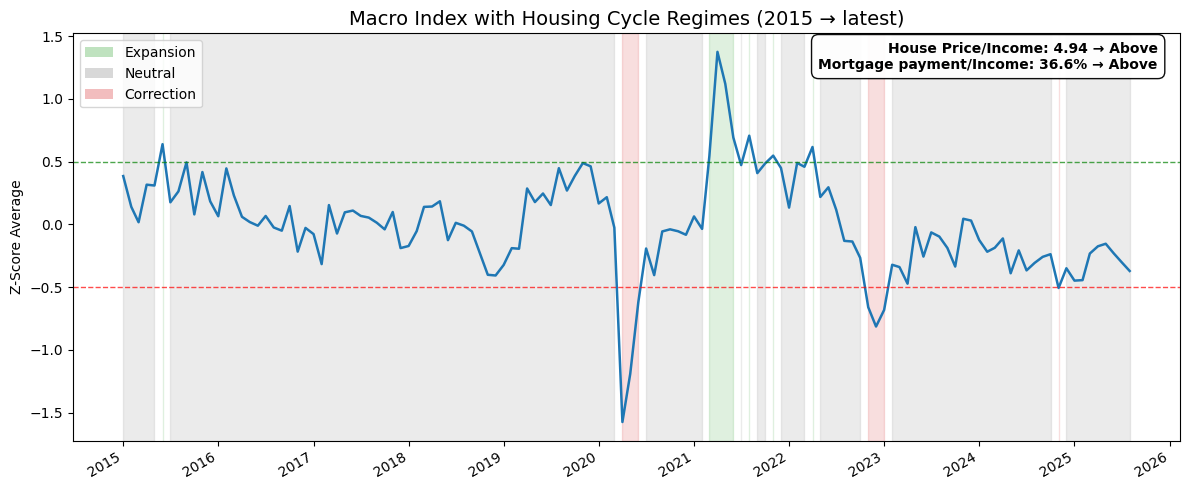

Chart saved to: ..\data\gold\fred\macro_index_regime.png


In [18]:
# Chart A: Macro Index with Regime Shading
plot_df = df.filter(pl.col("date") >= pl.datetime(2015, 1, 1))
dates = plot_df["date"].to_list()

if "macro_index" in plot_df.columns and "macro_regime" in plot_df.columns:
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dates, plot_df["macro_index"].to_list(), color="#1f77b4", lw=1.8, label="Macro Index")

    # Regime shading
    regimes = plot_df["macro_regime"].to_list()
    colors = {"Expansion": "#2ca02c", "Neutral": "#7f7f7f", "Correction": "#d62728"}
    start_idx = 0
    for i in range(1, len(regimes)):
        if regimes[i] != regimes[i - 1]:
            if regimes[i - 1] in colors:
                ax.axvspan(dates[start_idx], dates[i - 1], color=colors[regimes[i - 1]], alpha=0.15)
            start_idx = i
    # Final segment
    if start_idx < len(regimes) and regimes[-1] in colors:
        ax.axvspan(dates[start_idx], dates[-1], color=colors[regimes[-1]], alpha=0.15)

    ax.axhline(0.5, color="g", ls="--", lw=1, alpha=0.7)
    ax.axhline(-0.5, color="r", ls="--", lw=1, alpha=0.7)
    ax.set_title("Macro Index with Housing Cycle Regimes (2015 → latest)", fontsize=14)
    ax.set_ylabel("Z-Score Average")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()

    # Add affordability summary box if available
    if "pi_status" in plot_df.columns and "payi_status" in plot_df.columns:
        latest = plot_df.tail(1)
        pi_val = latest["price_to_income"].item()
        payi_val = latest["payment_to_income"].item()
        pi_status = latest["pi_status"].item() or "N/A"
        payi_status = latest["payi_status"].item() or "N/A"

        if pi_val is not None and payi_val is not None:
            summary_text = (
                f"House Price/Income: {pi_val:.2f} → {pi_status.split()[0]}\n"
                f"Mortgage payment/Income: {payi_val:.1%} → {payi_status.split()[0]}"
            )
            ax.text(0.98, 0.98, summary_text,
                    transform=ax.transAxes,
                    fontsize=10, fontweight='bold',
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="black"))
    
    legend_patches = [Patch(facecolor=c, alpha=0.3, label=r) for r, c in colors.items()]
    ax.legend(handles=legend_patches, loc="upper left")

    plt.tight_layout()
    fig.savefig(FIG_A, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Chart saved to: {FIG_A}")

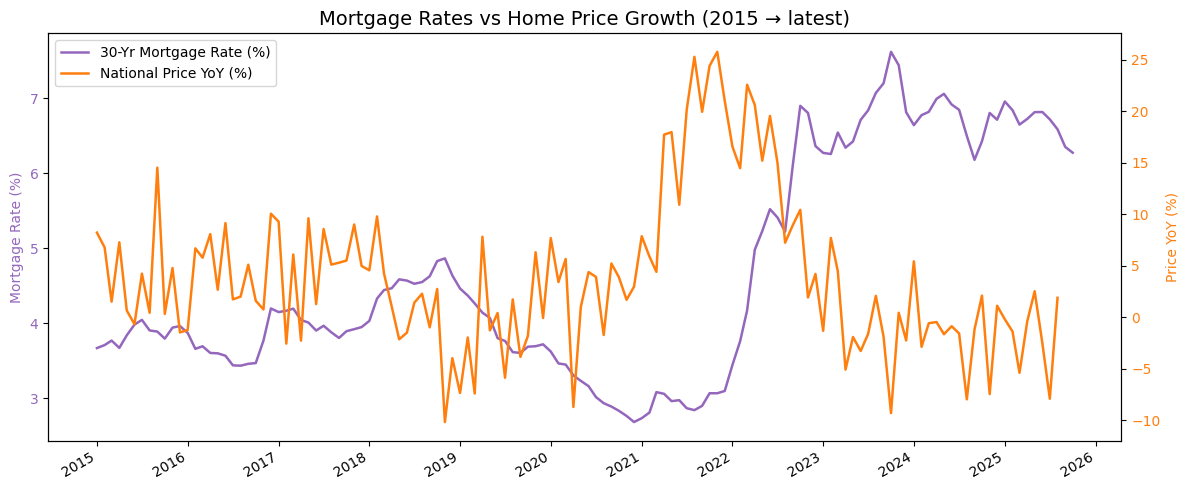

Chart saved to: ..\data\gold\fred\mortgage_vs_price_yoy.png


In [19]:
# Chart B: Mortgage Rate vs Price YoY
if "mortgage_rate" in plot_df.columns and "natl_price_yoy" in plot_df.columns:
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(dates, plot_df["mortgage_rate"].to_list(), color="#9467bd", lw=1.8, label="30-Yr Mortgage Rate (%)")
    ax1.set_ylabel("Mortgage Rate (%)", color="#9467bd")
    ax1.tick_params(axis="y", labelcolor="#9467bd")

    ax2 = ax1.twinx()
    price_yoy_pct = (plot_df["natl_price_yoy"] * 100).to_list()
    ax2.plot(dates, price_yoy_pct, color="#ff7f0e", lw=1.8, label="National Price YoY (%)")
    ax2.set_ylabel("Price YoY (%)", color="#ff7f0e")
    ax2.tick_params(axis="y", labelcolor="#ff7f0e")

    ax1.set_title("Mortgage Rates vs Home Price Growth (2015 → latest)", fontsize=14)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    fig.savefig(FIG_B, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Chart saved to: {FIG_B}")

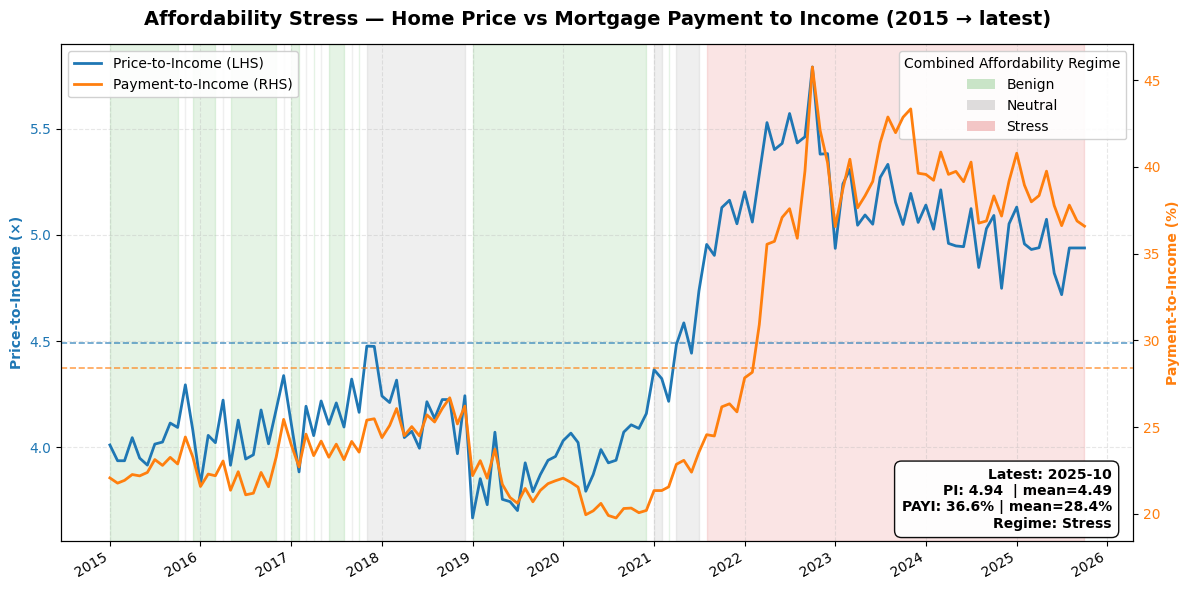

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import polars as pl
import numpy as np

# --- guard rails ---
need_cols = {"date", "price_to_income", "payment_to_income", "pi_status", "payi_status"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {sorted(missing)}")

# --- filter window ---
plot_df = (
    df
    .filter(pl.col("date") >= pl.datetime(2015, 1, 1))
    .select(["date", "price_to_income", "payment_to_income", "pi_status", "payi_status"])
    .sort("date")
)

dates = plot_df["date"].to_list()
pi = plot_df["price_to_income"].to_list()
payi = plot_df["payment_to_income"].to_list()  # fraction (e.g., 0.32)

# Historical means (2015+)
pi_mean = float(plot_df["price_to_income"].mean())
payi_mean = float(plot_df["payment_to_income"].mean())

# --- build combined affordability regime per timestamp ---
# Green  : both Below Trend
# Yellow : any At Trend and none Above
# Red    : any Above Trend
def combine_regime(pi_s: str | None, payi_s: str | None) -> str:
    tags = {pi_s or "", payi_s or ""}
    if "Above Trend (Red)" in tags:
        return "Stress"
    if "Below Trend (Green)" in tags and "At Trend (Yellow)" not in tags and "Above Trend (Red)" not in tags:
        return "Benign"
    # otherwise mixed/neutral
    return "Neutral"

regimes = [
    combine_regime(pi_s, payi_s)
    for pi_s, payi_s in zip(plot_df["pi_status"].to_list(), plot_df["payi_status"].to_list())
]

regime_colors = {"Benign": "#2ca02c", "Neutral": "#7f7f7f", "Stress": "#d62728"}

# --- plotting ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: Price-to-Income (ratio)
l1, = ax1.plot(dates, pi, color="#1f77b4", lw=2, label="Price-to-Income (LHS)")
ax1.axhline(pi_mean, color="#1f77b4", lw=1.2, ls="--", alpha=0.7, label=f"PI mean ({pi_mean:.2f})")
ax1.set_ylabel("Price-to-Income (×)", color="#1f77b4", fontweight="bold")
ax1.tick_params(axis="y", labelcolor="#1f77b4")

# Right axis: Payment-to-Income (percent)
ax2 = ax1.twinx()
l2, = ax2.plot(dates, [x*100 if x is not None else None for x in payi],
               color="#ff7f0e", lw=2, label="Payment-to-Income (RHS)")
ax2.axhline(payi_mean*100, color="#ff7f0e", lw=1.2, ls="--", alpha=0.7,
            label=f"PAYI mean ({payi_mean*100:.1f}%)")
ax2.set_ylabel("Payment-to-Income (%)", color="#ff7f0e", fontweight="bold")
ax2.tick_params(axis="y", labelcolor="#ff7f0e")

# Regime shading (continuous blocks)
start = 0
for i in range(1, len(regimes)):
    if regimes[i] != regimes[i-1]:
        c = regime_colors.get(regimes[i-1], "#cccccc")
        ax1.axvspan(dates[start], dates[i-1], color=c, alpha=0.12)
        start = i
# last block
if dates:
    c = regime_colors.get(regimes[-1], "#cccccc")
    ax1.axvspan(dates[start], dates[-1], color=c, alpha=0.12)

# X-axis formatting
ax1.set_title("Affordability Stress — Home Price vs Mortgage Payment to Income (2015 → latest)",
              fontsize=14, fontweight="bold", pad=14)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.grid(True, alpha=0.3, ls="--")
fig.autofmt_xdate()

# Legend: combine lines + regime swatches
line_legend = ax1.legend(handles=[l1, l2], loc="upper left", framealpha=0.9)
handles = [Patch(facecolor=c, alpha=0.25, label=lab) for lab, c in regime_colors.items()]
ax1.legend(handles=handles, loc="upper right", framealpha=0.9, title="Combined Affordability Regime")
ax1.add_artist(line_legend)

# Latest snapshot box
if len(dates) > 0:
    last_pi = pi[-1]
    last_payi = payi[-1]
    last_reg = regimes[-1]
    box = (f"Latest: {dates[-1].strftime('%Y-%m')}\n"
           f"PI: {last_pi:.2f}  | mean={pi_mean:.2f}\n"
           f"PAYI: {last_payi*100:.1f}% | mean={payi_mean*100:.1f}%\n"
           f"Regime: {last_reg}")
    ax1.text(0.98, 0.02, box, transform=ax1.transAxes,
             ha="right", va="bottom", fontsize=10, fontweight="bold",
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black", alpha=0.95))

plt.tight_layout()
plt.show()



## 10. Data Summary

In [20]:
# Display summary of the enriched dataset
print("\n=== FINAL DATASET SUMMARY ===")
print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nKey metrics (last 12 months):")

recent_df = df.tail(12)
if "macro_index" in recent_df.columns:
    print(f"  Avg Macro Index: {recent_df['macro_index'].mean():.3f}")
if "natl_price_yoy" in recent_df.columns:
    print(f"  Avg Price YoY: {recent_df['natl_price_yoy'].mean()*100:.1f}%")
if "mortgage_rate" in recent_df.columns:
    print(f"  Avg Mortgage Rate: {recent_df['mortgage_rate'].mean():.2f}%")
if "price_to_income" in recent_df.columns:
    print(f"  Avg Price/Income: {recent_df['price_to_income'].mean():.2f}")


=== FINAL DATASET SUMMARY ===
Shape: (946, 34)
Date range: 1947-01-01 00:00:00 to 2025-10-01 00:00:00

Key metrics (last 12 months):
  Avg Macro Index: -0.322
  Avg Price YoY: -2.0%
  Avg Mortgage Rate: 6.69%
  Avg Price/Income: 4.93
